In [1]:
import pandas as pd
import numpy as np
import datetime as dt
from datetime import datetime
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('overall index.csv')

In [3]:
my_columns = {'<TICKER>':'Symbol','<DTYYYYMMDD>':'Date','<OPEN>':'Open','<HIGH>':'High','<LOW>':'Low','<CLOSE>':'Close','<VOL>':'Vol'}
df.rename(columns = my_columns,inplace = True )

In [4]:
def datetime_format(x):
    y= str(x)[:4]
    m= str(x)[4:6]
    d= str(x)[6:8]
    date = f'{y}-{m}-{d}'
    return date
df['Date'] = df['Date'].apply(lambda x: datetime_format(x))

In [5]:
df.set_index(['Date'],inplace= True)

In [6]:
df.shape

(3030, 6)

In [7]:
df['Close'].loc[df.index[1]]

9130.5

In [8]:
def pivot_finder(df):
    n = 5
    my_columns_high = ['Date','Pivot_high']
    pivot_high = pd.DataFrame( columns = my_columns_high)
    my_columns_low = ['Date','Pivot_low']
    pivot_low = pd.DataFrame( columns = my_columns_low)
    
    for i in range (n,df.shape[0]-n):
        for j in range(-n+1,n):
            a = df['High'].loc[df.index[i]] - df['High'].loc[df.index[i+j]]
            if (a < 0) :
                break
            elif ( a >= 0 and j==n-1):
                pivot_high = pivot_high.append(
                                        pd.Series([
                                            df.index[i],
                                            df['High'].loc[df.index[i]]
                                        ], 
                                            index = my_columns_high), 
                                        ignore_index = True)
        for j in range(-n+1,n):    
            a = df['Low'].loc[df.index[i]] - df['Low'].loc[df.index[i+j]]
            if (a > 0):
                break    
            elif ( a<0 and j==n-1):
                pivot_low = pivot_low.append(
                                        pd.Series([
                                            df.index[i],
                                            df['Low'].loc[df.index[i]],
                                        ], 
                                                  index = my_columns_low), 
                                        ignore_index = True)
    return pd.merge(pivot_high,pivot_low, on = 'Date', how='outer')
            
                

In [9]:
data = pivot_finder(df)
df = pd.merge(df,data,on = 'Date', how = 'left')


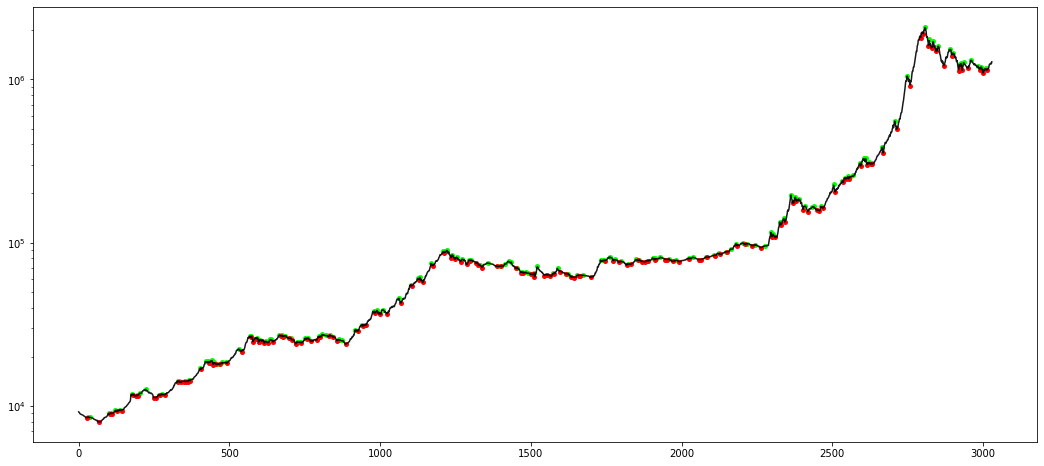

In [10]:
plt.figure(figsize=(18,8))
plt.plot(df['Close'],label = 'overall index', alpha =0.9,color = 'black')
plt.scatter(df.index,df['Pivot_high'], label= 'high', marker = '.', color = '#00ff00',lw=2)
plt.scatter(df.index,df['Pivot_low'], label= 'low', marker = '.', color = '#ff0000', lw=2)
plt.yscale('log')
plt.show()

In [11]:
def array_con(df):
    pivot_high = df['Pivot_high'][df['Pivot_high']>0][-4:].tolist()
    pivot_low = df['Pivot_low'][df['Pivot_low']>0][-4:].tolist()
    return np.array(pivot_high),np.array(pivot_low)

In [12]:
x= np.array([1,2,3,4])
buy  = []
sell = []
trigger = 0
stop_loss = 0

for row in df.index[200:]:
    if trigger == 0 : 
        y_high,y_low = array_con(df.head(row))
        m_high, b_high = np.polyfit(x, y_high, 1)
        m_low, b_low = np.polyfit(x, y_low, 1)
        del b_high,b_low
        
        if (m_high>0 and m_low>0):
            if df['Close'].loc[row] > y_high[-1]*1.03:
                trigger =1 
                stop_loss = max (y_low[-1]*(0.99),df['Close'].loc[row]*0.8)
                buy.append(df['Close'].iloc[row])
                sell.append(float("NaN"))
            else:
                buy.append(float("NaN"))
                sell.append(float("NaN"))
                
        else:
            buy.append(float("NaN"))
            sell.append(float("NaN"))
            
    elif trigger == 1 :
        if stop_loss >= df['Close'].iloc[row] :
            trigger = 0
            stop_loss = 0
            buy.append(float("NaN"))
            sell.append(df['Close'].iloc[row])
        else:
            
            buy.append(float("NaN"))
            sell.append(float("NaN"))
            y_high,y_low = array_con(df.head(row))
            stop_loss = max (y_low[-1]*(0.99),df['Close'].loc[row]*0.8)

In [13]:
dataset = df.tail(df.shape[0]-200)
dataset['buy'] = buy
dataset['sell'] = sell

<ipython-input-13-b188b10c138b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['buy'] = buy
<ipython-input-13-b188b10c138b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['sell'] = sell


In [14]:
dataset.reset_index(drop=True,inplace=True)

In [15]:
dataset.set_index('Date',inplace=True)
dataset

,Symbol,Open,High,Low,Close,Vol,Pivot_high,Pivot_low,buy,sell
Date,,,,,,,,,,
2009-10-06,Overall Index,11760.0,11792.8,11737.4,11792.8,162739488,NaN,NaN,NaN,NaN
2009-10-07,Overall Index,11822.3,11891.1,11822.3,11891.1,135981973,NaN,NaN,NaN,NaN
2009-10-10,Overall Index,11920.8,11962.5,11920.8,11957.9,174881498,NaN,NaN,NaN,NaN
2009-10-11,Overall Index,11963.3,11963.9,11925.2,11925.4,268445276,11963.9,NaN,NaN,NaN
2009-10-12,Overall Index,11940.3,11940.3,11912.3,11912.3,266983782,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2021-06-30,Overall Index,1249300.0,1256960.0,1248100.0,1256960.2,6152334613,NaN,NaN,NaN,NaN
2021-07-03,Overall Index,1258600.0,1258900.0,1246050.0,1246055.4,6308319007,NaN,NaN,NaN,NaN
2021-07-04,Overall Index,1242840.0,1244540.0,1237550.0,1243751.9,5329408022,NaN,NaN,NaN,NaN


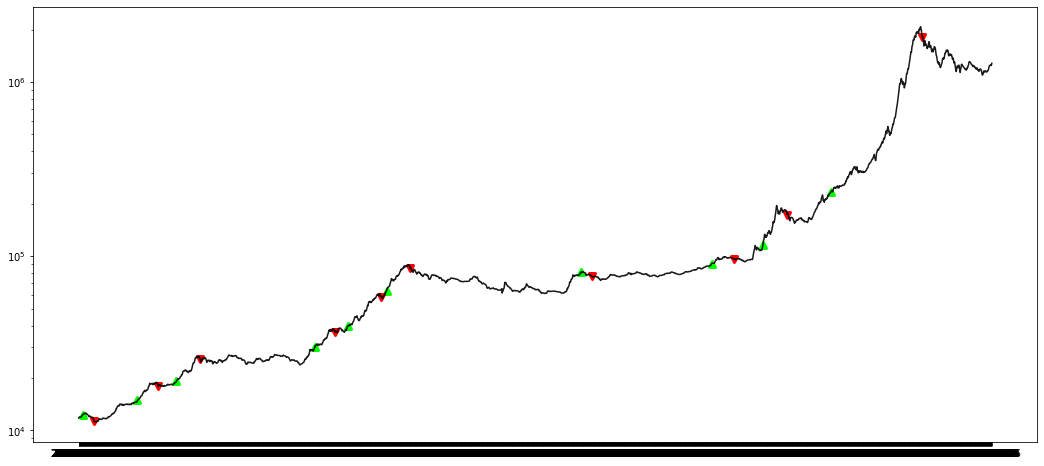

In [16]:
plt.figure(figsize=(18,8))
plt.plot(dataset['Close'],label = 'overall index', alpha =0.9,color = 'black')

plt.scatter(dataset.index,dataset['buy'], label= 'buy', marker = '^', color = '#00ff00',lw=3)
plt.scatter(dataset.index,dataset['sell'], label= 'sell', marker = 'v', color = '#ff0000', lw=3)
plt.yscale('log')
plt.show()

In [17]:
buy = dataset['buy'][dataset['buy'] > 0]
buy_date = buy.index.tolist()
buy_price = buy.tolist()

del buy

In [18]:
sell = dataset['sell'][dataset['sell'] > 0]
sell_date = sell.index.tolist()
sell_price = sell.tolist()
del sell

In [19]:
if len(buy_price) != len(sell_price):
    sell_date.append(dataset.index[-1])
    sell_price.append(dataset.Close[-1])

In [20]:
my_columns = ['buy_price','buy_date','sell_price','sell_date','return','duration']
Trades = pd.DataFrame( columns = my_columns)
Trades

,buy_price,buy_date,sell_price,sell_date,return,duration


In [21]:
for i in range(len(buy_price)):
    Trades = Trades.append(
                                        pd.Series([
                                                   buy_price[i],
                                                   buy_date[i],
                                                   sell_price[i],
                                                   sell_date[i],
                                                   (sell_price[i]-buy_price[i])/buy_price[i] ,
            (dt.datetime.strptime(sell_date[i], '%Y-%m-%d') - dt.datetime.strptime(buy_date[i], '%Y-%m-%d')).days
                                        ], 
                                                  index = my_columns), 
                                        ignore_index = True)

In [22]:
Trades

,buy_price,buy_date,sell_price,sell_date,return,duration
0,12325.8,2009-10-25,11362.5,2009-12-15,-0.078153,51
1,14883.4,2010-07-11,17902.5,2010-10-13,0.202850,94
2,19200.4,2011-01-04,25781.8,2011-04-27,0.342774,113
3,30211.4,2012-10-21,36594.0,2013-01-22,0.211265,93
4,39990.2,2013-03-31,58561.0,2013-08-31,0.464384,153
5,63455.3,2013-09-25,85404.1,2014-01-12,0.345894,109
6,81200.3,2016-03-26,76630.4,2016-05-10,-0.056279,45
7,90655.5,2017-11-26,96594.5,2018-03-10,0.065512,104
8,116759.5,2018-07-30,173557.7,2018-11-18,0.486455,111
9,234167.7,2019-06-15,1813574.5,2020-08-16,6.744768,428


In [23]:
y = 1
for x in Trades['return']:
    y = y*(1+x)
overall_return = (y-1) * 100

In [24]:
print(f'overall return in this backtest is {overall_return} %')

overall return in this backtest is 4014.7153479176827 %
